# Anomaly Detection of MNIST by AutoEncoder (PyTorch)

In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
data_path = pathlib.Path().cwd().parents[1] / 'data' / 'processed' / 'mnist'
model_storage_path = pathlib.Path().cwd().parent / 'models'
result_storage_path = pathlib.Path().cwd().parent / 'results'

In [3]:
model_path = model_storage_path / 'dad_autoencoder.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [5]:
epochs = 10
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-5

In [6]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None, is_training=False):
        mode = ''
        if is_training:
            mode = 'train'
        else:
            mode = 'test'
        self.transform = transform
        self.images = np.load(str(data_path / f'{mode}_images.npy')).astype(np.float32)
        self.labels = np.load(str(data_path / f'{mode}_labels.npy'))
        self.size = len(self.labels)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((128.0,), (128.0,)),  # [-1,1]
    ])

In [8]:
train_dataset = MNISTDataset(data_path, transform=transformer, is_training=True)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
model = AutoEncoder().to(device)

In [12]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [13]:
def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    )

In [15]:
loss_list = []
for epoch in range(1, 1+epochs):
    for data in train_loader:
        img, _ = data
        x = img.view(img.size(0), -1)
        x = Variable(x).to(device)
        
        xhat = model(x)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
        # logging
        loss_list.append(loss)
    
    print(f'Epoch [{epoch}/{epochs}] \t Loss: {loss:.4f}')

    # 10エポックごとに再構成された画像（xhat）を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.cpu().data)
        save_image(pic, str(result_storage_path / f'image_{epoch}.png'))
np.save(str(result_storage_path / 'loss_list.npy'), np.array(loss_list))

Epoch [1/10] 	 Loss: 0.1256
Epoch [2/10] 	 Loss: 0.1081
Epoch [3/10] 	 Loss: 0.0915
Epoch [4/10] 	 Loss: 0.0668
Epoch [5/10] 	 Loss: 0.0584
Epoch [6/10] 	 Loss: 0.0564
Epoch [7/10] 	 Loss: 0.0540
Epoch [8/10] 	 Loss: 0.0455
Epoch [9/10] 	 Loss: 0.0565
Epoch [10/10] 	 Loss: 0.0486


In [16]:
torch.save(model.state_dict(), str(model_path))

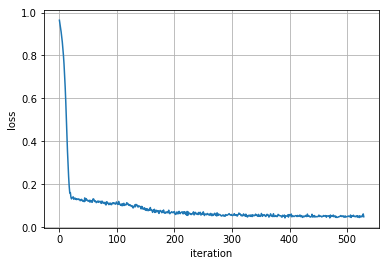

In [17]:
#loss_list = np.loadstr(result_storage_path / 'loss_list.npy'))
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.show()

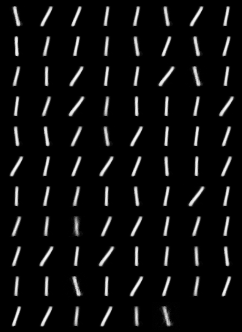

In [18]:
from IPython.display import Image, display_png
Image(filename=str(result_storage_path / 'image_10.png'))

In [19]:
batch_size_test = 10000

In [20]:
model.load_state_dict(torch.load(str(model_path)))

In [34]:
test_dataset = MNISTDataset(data_path, transform=transformer, is_training=False)

In [35]:
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [36]:
images, labels = iter(test_loader).next()
images = images.view(images.shape[0], -1)

In [37]:
x_hat = model(images).cpu().data.numpy()

In [45]:
x = images.cpu().data.numpy()
y = labels.cpu().data.numpy()

In [46]:
n = 6
start_idx = 10

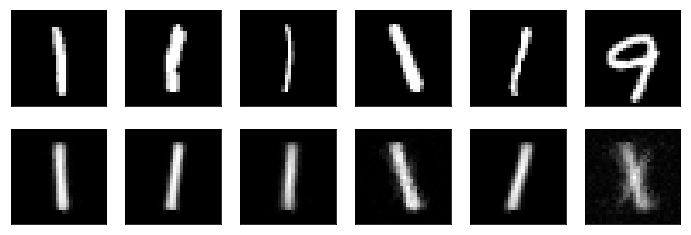

In [47]:
plt.figure(figsize=(12, 4))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x[start_idx+i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # 出力画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(x_hat[start_idx+i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(str(result_storage_path / 'result.png'))
plt.show()

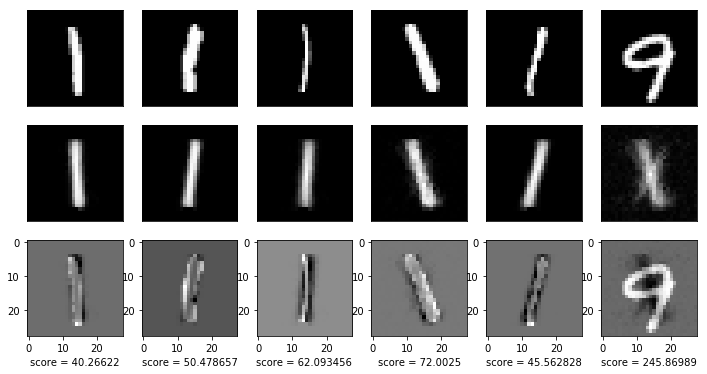

In [48]:
plt.figure(figsize=(12, 6))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x[start_idx+i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # 出力画像を表示
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(x_hat[start_idx+i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 入出力の差分画像を計算
    diff_img = x[start_idx+i] - x_hat[start_idx+i]
    
    # 入出力の差分数値を計算
    diff = np.sum(np.abs(x[start_idx+i]-x_hat[start_idx+i]))

    # 差分画像と差分数値の表示
    ax = plt.subplot(3, n, i+1+n*2)
    plt.imshow(diff_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True) 
    ax.set_xlabel('score = '+str(diff))    
        
plt.savefig("result.png")
plt.show()
plt.close()

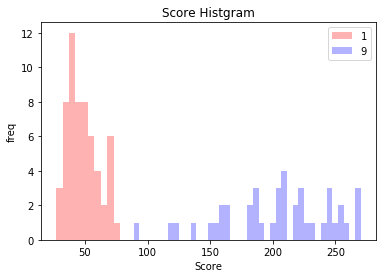

In [49]:
import os
if os.path.exists('scores_1.txt'):
    os.remove('scores_1.txt')
if os.path.exists('scores_9.txt'):
    os.remove('scores_9.txt')

# score の計算、結果のファイル保存
for i in range(100):
    score = np.sum(np.abs(x[i]-x_hat[i]))
    
    if y[i] == 1:
        with open('scores_1.txt','a') as f:
            f.write(str(score)+'\n')            
    else:
        with open('scores_9.txt','a') as f:
            f.write(str(score)+'\n')

# ファイルを元にヒストグラムの表示
import csv
    
x = []
with open('scores_1.txt', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        row = int(float(row[0]))
        x.append(row)
y = []
with open('scores_9.txt', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        row = int(float(row[0]))
        y.append(row)
             
plt.title("Score Histgram")
plt.xlabel("Score")
plt.ylabel("freq")
plt.hist(x, bins=10, alpha=0.3, histtype='stepfilled', color='r', label="1")
plt.hist(y, bins=40, alpha=0.3, histtype='stepfilled', color='b', label='9')
plt.legend(loc=1)
plt.savefig("histgram.png")
plt.show()
plt.close()